# Example: Mixed-Element Mesh for Delineated Watershed

This workflow provides a complete working example to develop an streamaligned mixed-element mesh for Coweeta watershed. Long quad elements with pentagons at junctions are placed along NHDPlus flowlines to represent rivers/streams. Rest of the domain is meshed with standard TIN.

It uses the following datasets:

* `NHD Plus` for the watershed boundary and hydrography.
* `NED` for elevation
* `NLCD` for land cover/transpiration/rooting depths
* `GLYHMPS` geology data for structural formations
* `SoilGrids 2017` for depth to bedrock and soil texture information
* `SSURGO` for soil data, where available, in the top 2m.

This workflow creates the following files:

* Mesh file: `Coweeta.exo`, includes all labeled sets


In [1]:
## Importing all the package needed to run teh watershed workflow
# conda package imports
import os,sys
import numpy as np
import pandas
from matplotlib import pyplot as plt
import logging
import pandas as pd
import copy
import scipy
import shapely

import watershed_workflow 
import watershed_workflow.source_list
import watershed_workflow.ui
import watershed_workflow.utils
import watershed_workflow.plot
import watershed_workflow.mesh
import watershed_workflow.densification
import watershed_workflow.condition
import watershed_workflow.regions
watershed_workflow.ui.setup_logging(1,None)

In [2]:
## Parameters cell -- this provides all parameters that can be changed via pipelining to generate a new watershed. 
coweeta_shapefile = './BSF/input_data/BSF_USGS_UTM_12.shp'
hint = '0601'  # hint: HUC 4 containing this shape.  
               # This is necessary to avoid downloading all HUCs to search for this shape
name = 'BSF'
modis_name = None

figsize = (6,6)
figsize_3d = (8,6)

# Geomtric parameters tuning the degree of cleaning of the raw data and scales of hydrologic features to be considered
simplify = 60 # length scale to target average edge
ignore_small_rivers = 2 
prune_by_area_fraction = 0.01 

# huc boundary refinement control
refine_d0 = 20
refine_d1 = 100
refine_L0 = 70
refine_L1 = 200

In [3]:
# Note that, by default, we tend to work in the DayMet CRS because this allows us to avoid
# reprojecting meteorological forcing datasets.
crs = watershed_workflow.crs.daymet_crs()

## Sources and setup

Next we set up the source watershed and coordinate system and all data sources for our mesh.  We will use the CRS that is included in the shapefile.

A wide range of data sources are available; here we use the defaults except for using NHD Plus for watershed boundaries and hydrography (the default is NHD, which is lower resolution and therefore smaller download sizes).

In [4]:
# set up a dictionary of source objects
sources = watershed_workflow.source_list.get_default_sources()
sources['hydrography'] = watershed_workflow.source_list.hydrography_sources['NHD Plus']
sources['HUC'] = watershed_workflow.source_list.huc_sources['NHD Plus']
sources['depth to bedrock'] = watershed_workflow.source_list.FileManagerSoilGrids2017()


#
# This demo uses a few datasets that have been clipped out of larger, national
# datasets and are distributed with the code.  This is simply to save download
# time for this simple problem and to lower the barrier for trying out
# Watershed Workflow.  A more typical workflow would delete these lines (as 
# these files would not exist for other watersheds).
#
# The default versions of these download large raster and shapefile files that
# are defined over a very large region (globally or the entire US).
#
# Note we also prepopulate some data for MODIS data as well.
#
sources['land cover'] = watershed_workflow.source_list.FileManagerRaster('BSF/input_data/land_cover/LC_BSF.tif')
sources['geologic structure'] = watershed_workflow.source_list.FileManagerGLHYMPS('BSF/input_data/GLHYMPS/GLHYMPS_BSF.shp')
sources['depth to bedrock'] = watershed_workflow.source_list.FileManagerRaster('BSF/input_data/DTB/DTB.tif')
watershed_workflow.source_list.log_sources(sources)

2023-11-12 12:56:45,815 - root - INFO: Using sources:
2023-11-12 12:56:45,815 - root - INFO: --------------
2023-11-12 12:56:45,822 - root - INFO: HUC: National Hydrography Dataset Plus High Resolution (NHDPlus HR)
2023-11-12 12:56:45,823 - root - INFO: hydrography: National Hydrography Dataset Plus High Resolution (NHDPlus HR)
2023-11-12 12:56:45,825 - root - INFO: DEM: National Elevation Dataset (NED)
2023-11-12 12:56:45,827 - root - INFO: soil structure: National Resources Conservation Service Soil Survey (NRCS Soils)
2023-11-12 12:56:45,829 - root - INFO: geologic structure: BSF/input_data/GLHYMPS/GLHYMPS_BSF.shp
2023-11-12 12:56:45,831 - root - INFO: land cover: raster
2023-11-12 12:56:45,832 - root - INFO: lai: MODIS
2023-11-12 12:56:45,833 - root - INFO: soil thickness: None
2023-11-12 12:56:45,834 - root - INFO: meteorology: DayMet 1km
2023-11-12 12:56:45,836 - root - INFO: depth to bedrock: raster


### Get HUCs

In [5]:
# load hucs from shape
_, watershed = watershed_workflow.get_split_form_shapes(coweeta_shapefile, out_crs=crs)

2023-11-12 12:56:45,853 - root - INFO: 
2023-11-12 12:56:45,855 - root - INFO: Loading shapes
2023-11-12 12:56:45,856 - root - INFO: ------------------------------
2023-11-12 12:56:45,858 - root - INFO: Loading file: './BSF/input_data/BSF_USGS_UTM_12.shp'
2023-11-12 12:56:46,072 - root - INFO: ... found 1 shapes
2023-11-12 12:56:46,077 - root - INFO: Converting to shapely
2023-11-12 12:56:46,088 - root - INFO:  ... done
2023-11-12 12:56:46,109 - root - INFO: Converting to requested CRS
2023-11-12 12:56:46,250 - root - INFO:  ... done
2023-11-12 12:56:46,250 - root - INFO: Removing holes on 1 polygons
2023-11-12 12:56:46,266 - root - INFO:   -- removed interior
2023-11-12 12:56:46,266 - root - INFO:   -- union
2023-11-12 12:56:46,276 - root - INFO: Parsing 1 components for holes
2023-11-12 12:56:46,278 - root - INFO:   -- complete


### Get Rivers 

In [6]:
include_rivers=True

if include_rivers:  
    # download/collect the river network within that shape's bounds
    _, reaches = watershed_workflow.get_reaches(sources['hydrography'], hint, 
                                                watershed.exterior(), crs, crs,
                                                in_network=True, properties=True)
    
    rivers = watershed_workflow.construct_rivers(reaches, method='hydroseq',
                                                 ignore_small_rivers=ignore_small_rivers,
                                                 prune_by_area=prune_by_area_fraction * watershed.exterior().area * 1.e-6,
                                                 remove_diversions=True,
                                                 remove_braided_divergences=True)
    
    # keeping the originals
    rivers_orig=[river.deepcopy() for river in rivers]
    watershed_orig=copy.deepcopy(watershed) 
    
    # simplifying 
    rivers = watershed_workflow.simplify(watershed, rivers, simplify_hucs=simplify, simplify_rivers=simplify,
                               snap_tol=0, cut_intersections=False)
    
    # for plotting purpose only
    rivers_simplified=[river.deepcopy() for river in rivers] 
    watershed_simplified=copy.deepcopy(watershed) 

else:
    reaches = []
    rivers = []

2023-11-12 12:56:46,323 - root - INFO: 
2023-11-12 12:56:46,325 - root - INFO: Loading Hydrography
2023-11-12 12:56:46,328 - root - INFO: ------------------------------
2023-11-12 12:56:46,330 - root - INFO: Loading streams in HUC 0601
2023-11-12 12:56:46,333 - root - INFO:          and/or bounds (-938147.4704816904, -46858.27379953274, -903075.9019984158, -6172.107564101888)
2023-11-12 12:56:46,339 - root - INFO:   Using Hydrography file "C:\Users\jihad\watershed-workflow\examples\data\hydrography\NHDPlus_H_0601_GDB\NHDPlus_H_0601.gdb"
2023-11-12 12:56:46,340 - root - INFO:   National Hydrography Dataset Plus High Resolution (NHDPlus HR): opening 'C:\Users\jihad\watershed-workflow\examples\data\hydrography\NHDPlus_H_0601_GDB\NHDPlus_H_0601.gdb' layer 'NHDFlowline' for streams in '(-938147.4704816904, -46858.27379953274, -903075.9019984158, -6172.107564101888)'
2023-11-12 12:57:01,518 - root - INFO:   Found total of 0 in bounds.
2023-11-12 12:57:01,528 - root - INFO:   Filtering reache

Original watershed and river trees are kept for resampling at a desired resolution in the final watershed and rivertree

### Plotting original and simplified-pruned rivers and watershed


C:\Users\jihad\miniforge-pypy3\envs\ENV_ATS\lib\site-packages\pyproj\crs\crs.py:1286: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


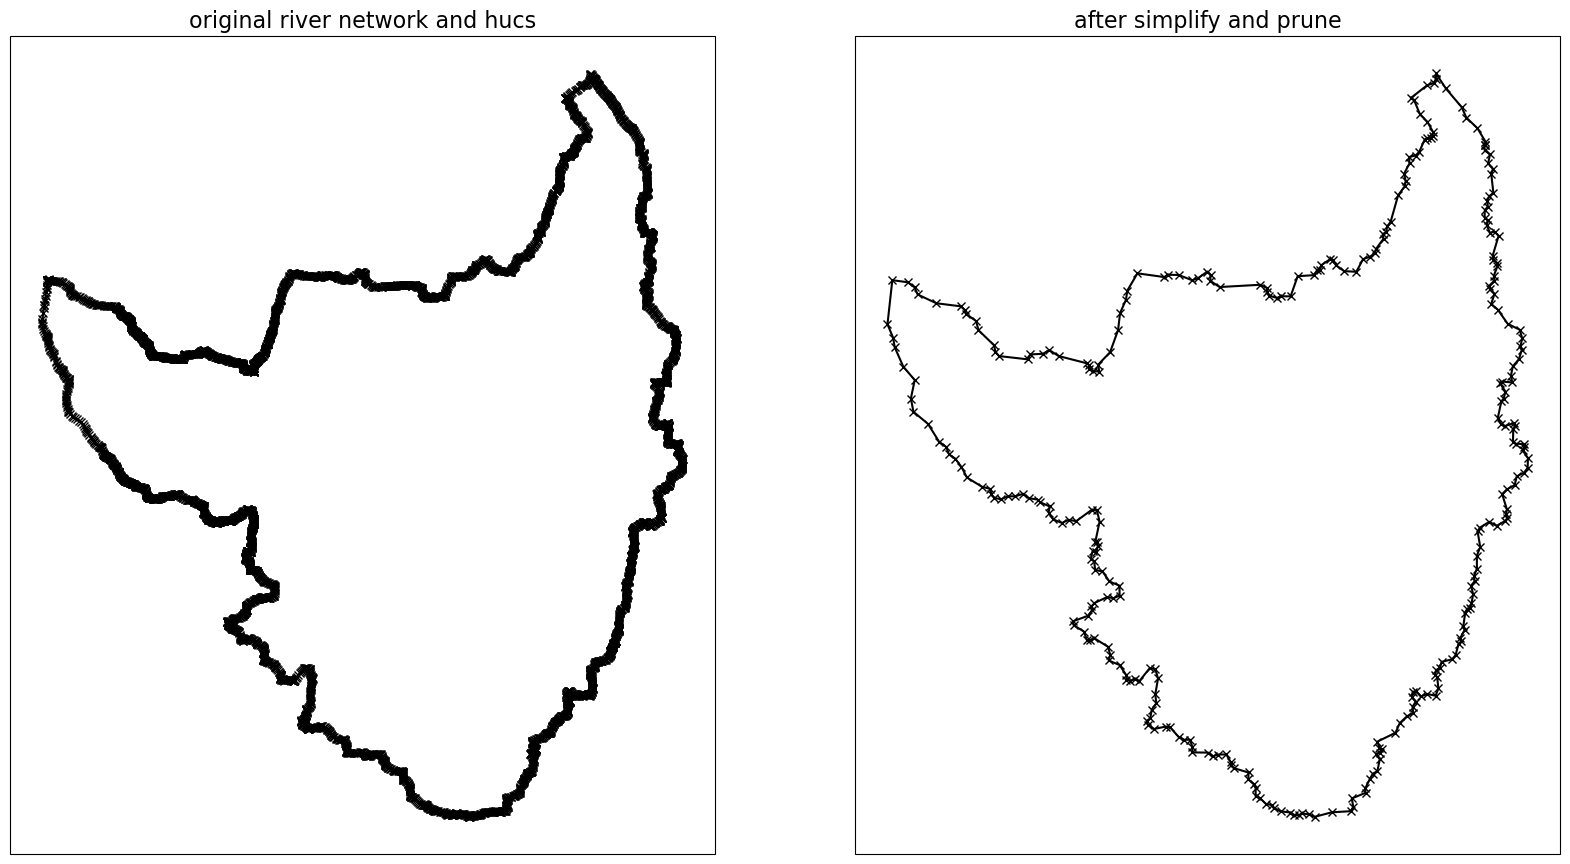

In [7]:
plt.rcParams['figure.figsize'] = [20, 20]

fig, axs = plt.subplots(1,2,subplot_kw={'projection':watershed_workflow.crs.to_cartopy(crs)})

axs[0].plot(watershed_orig.exterior().exterior.xy[0], watershed_orig.exterior().exterior.xy[1], 'k-x')
axs[0].set_title('original river network and hucs',fontsize=16)
axs[1].plot(watershed.exterior().exterior.xy[0], watershed.exterior().exterior.xy[1], 'k-x')
axs[1].set_title('after simplify and prune',fontsize=16)

for river in rivers_orig:
    for node in river.preOrder():
        x,y=node.segment.xy 
        axs[0].plot(x,y,'-o',markersize=5)

for river in rivers_simplified:
    for node in river.preOrder():
        x,y=node.segment.xy 
        axs[1].plot(x,y,'-o',markersize=5)

### Densification of River Network and Watershed

In [8]:
d0 = refine_d0; d1 = refine_d1
L0 = refine_L0; L1 = refine_L1 

# densify_watershed
watershed_workflow.densification.densify_hucs(watershed, watershed_orig, rivers, limit_scales=[d0,L0,d1,L1]) 

#densify_river
watershed_workflow.densification.densify_rivers(rivers, rivers_orig, limit=70)



# treat sharp angles
watershed_workflow.densification.remove_sharp_angles(rivers, watershed, angle_limit=10, junction_angle_limit=10, huc_seg_river_angle_limit=10, limit=70)

ValueError: min() arg is an empty sequence

In [ ]:
# comparing original, simplified and re-densified huc and river
plt.rcParams['figure.figsize'] = [30, 20]

fig, axs = plt.subplots(1,3,subplot_kw={'projection':watershed_workflow.crs.to_cartopy(crs)})

axs[0].plot(watershed_orig.exterior().exterior.xy[0], watershed_orig.exterior().exterior.xy[1], 'k-x')
axs[0].set_title('original river network and hucs',fontsize=16)
axs[1].plot(watershed_simplified.exterior().exterior.xy[0], watershed_simplified.exterior().exterior.xy[1], 'k-x')
axs[1].set_title('after simplify and prune',fontsize=16)
axs[2].plot(watershed.exterior().exterior.xy[0], watershed.exterior().exterior.xy[1], 'k-x')
axs[2].set_title('re-densified',fontsize=16)
axs[2].plot()

for river in rivers_orig:
    for node in river.preOrder():
        x,y=node.segment.xy 
        axs[0].plot(x,y,'-o',markersize=5)

for river in rivers_simplified:
    for node in river.preOrder():
        x,y=node.segment.xy 
        axs[1].plot(x,y,'-o',markersize=5)

for river in rivers:
    for node in river.preOrder():
        x,y=node.segment.xy 
        axs[2].plot(x,y,'-o',markersize=5)

In [ ]:
# how many types of Stream Orders are there
set([r.properties["StreamOrder"] for r in rivers[0].preOrder()])

## Meshing Begin

In [ ]:
## Triangulation

# Refine triangles if they get too acute
min_angle = 32 # degrees

# width of reach by stream order (order:width)
widths = dict({1:8,2:12,3:16})

mesh_points2, conn_list, areas, dists = watershed_workflow.tessalate_river_aligned(watershed,rivers, river_width=widths,
                                              refine_min_angle=min_angle,refine_max_area=30000,
                                              diagnostics=True)

In [ ]:
# get a raster for the elevation map, based on NED
dem_profile, dem = watershed_workflow.get_raster_on_shape(sources['DEM'], watershed.exterior(), crs)

# elevate the triangle nodes to the dem
mesh_points3 = watershed_workflow.elevate(mesh_points2, crs, dem, dem_profile)

In [ ]:
# construct the 2D mesh
m2 = watershed_workflow.mesh.Mesh2D(mesh_points3.copy(), conn_list)

In [ ]:
# hydrologically condition the mesh, removing pits
river_mask=np.zeros((len(m2.conn)))
for i, elem in enumerate(m2.conn):
    if not len(elem)==3:
        river_mask[i]=1     
watershed_workflow.condition.fill_pits_dual(m2, is_waterbody=river_mask)

In [ ]:
# conditioning river mesh
#
# adding elevations to the river tree for stream bed conditioning
watershed_workflow.condition.elevate_rivers(rivers, crs, dem, dem_profile)

# conditioning the river mesh using NHD elevations
watershed_workflow.condition.condition_river_mesh(m2, river)

In [ ]:
# plotting surface mesh with elevations
start=min(m2.centroids[:,2])
step=(max(m2.centroids[:,2])-(min(m2.centroids[:,2])))/40
stop=max(m2.centroids[:,2])+step
legend_values=np.arange(start,stop,step)
indices, cmap, norm, ticks, labels = watershed_workflow.colors.generate_indexed_colormap(legend_values, cmap='jet')


fig = plt.figure(figsize=figsize)
ax = watershed_workflow.plot.get_ax(crs, fig, window=[0.05,0.1,0.9,0.8])
ax2 = ax.inset_axes([0.65,0.05,0.3,0.5])
cbax = fig.add_axes([0.05,0.05,0.9,0.05])

mp = watershed_workflow.plot.mesh(m2, crs, ax=ax, 
                        linewidth=0.5 ,color=m2.centroids[:,2], 
                        cmap=cmap, norm = norm, edgecolor='k', facecolor='color')
cbar = fig.colorbar(mp, orientation="horizontal", cax=cbax)
ax.set_title('surface mesh with elevations')
ax.set_aspect('equal', 'datalim')

mp2 = watershed_workflow.plot.mesh(m2, crs, ax=ax2, 
                        linewidth=0.5 ,color=m2.centroids[:,2], 
                        cmap=cmap, norm = norm, edgecolor='k', facecolor='color')
ax2.set_aspect('equal', 'datalim')

xlim = (1.4433e6, 1.4438e6)
ylim = (-647000, -647500)

ax2.set_xlim(xlim)
ax2.set_ylim(ylim)
ax2.set_xticks([])
ax2.set_yticks([])

ax.indicate_inset_zoom(ax2, edgecolor='k')

cbar.ax.set_title('elevation [m]')

plt.show()


## Surface properties

Meshes interact with data to provide forcing, parameters, and more in the actual simulation.  Specifically, we need vegetation type on the surface to provide information about transpiration and subsurface structure to provide information about water retention curves, etc.

We'll start by downloading and collecting land cover from the NLCD dataset, and generate sets for each land cover type that cover the surface.  Likely these will be some combination of grass, deciduous forest, coniferous forest, and mixed forest.

In [ ]:
# download the NLCD raster
lc_profile, lc_raster = watershed_workflow.get_raster_on_shape(sources['land cover'], 
                                                     watershed.exterior(), crs)

# resample the raster to the triangles
lc = watershed_workflow.values_from_raster(m2.centroids, crs, lc_raster, lc_profile)

# what land cover types did we get?
logging.info('Found land cover dtypes: {}'.format(lc.dtype))
logging.info('Found land cover types: {}'.format(set(lc)))


In [ ]:
# plot the NLCD data

# -- get the NLCD colormap which uses official NLCD colors and labels
nlcd_indices, nlcd_cmap, nlcd_norm, nlcd_ticks, nlcd_labels = \
                watershed_workflow.colors.generate_nlcd_colormap(lc)

# plot the image
fig = plt.figure(figsize=figsize)
ax = watershed_workflow.plot.get_ax(crs, fig)

polys = watershed_workflow.plot.mesh(m2, crs, ax=ax, color=lc, cmap=nlcd_cmap, 
                                     norm=nlcd_norm, edgecolor='none', 
                                     facecolor='color', linewidth=0.5)
watershed_workflow.colors.colorbar_index(ncolors=len(nlcd_indices), cmap=nlcd_cmap, 
                                         labels=nlcd_labels) 
ax.set_title("NLCD land cover index")

Add regions for the land cover types, river corridor and reaches of each order

In [ ]:
# add labeled sets to the mesh for NLCD
nlcd_labels_dict = dict(zip(nlcd_indices, nlcd_labels))
watershed_workflow.regions.add_nlcd_labeled_sets(m2, lc, nlcd_labels_dict)

In [ ]:
## add labeled sets for river corridor cells 
watershed_workflow.regions.add_river_corridor_regions(m2, rivers)

In [ ]:
## add labeled sets for river corridor cells for reaches each stream order 
watershed_workflow.regions.add_regions_by_stream_order_rivers(m2, rivers)

In [ ]:
## example of adding region for a reach by reach id
watershed_workflow.regions.add_region_by_reach_id(m2, rivers, reach_ids=[str(25000400040729)])

In [ ]:
for ls in m2.labeled_sets:
    print(f'{ls.setid} : {ls.entity} : {len(ls.ent_ids)} : "{ls.name}"')

## Subsurface properties

The default model uses GLHYMPS to identify geologic formations, and 

In [ ]:
# download the NRCS soils data as shapes and project it onto the mesh
#
soil_profile, soil_survey, soil_survey_props = \
        watershed_workflow.get_shapes(sources['soil structure'], list(watershed.polygons()), crs, 
                                                     crs, properties=True)

# -- determine the NRCS mukey for each soil unit; this uniquely identifies soil 
#    properties
soil_ids = list(soil_survey_props['mukey'][:])
soil_survey_props.set_index('mukey', inplace=True)

# -- color a raster by the polygons (this makes identifying a triangle's value much 
#    more efficient)
soil_color_profile, soil_color_raster = watershed_workflow.color_raster_from_shapes(soil_survey, crs, soil_ids,
                                                                                    watershed.exterior().bounds, 10, crs, -1)

# -- resample the raster to the triangles
soil_color = watershed_workflow.values_from_raster(m2.centroids, crs, 
                                         soil_color_raster, soil_color_profile)
soil_survey_props

Select only the soils within the watershed

In [ ]:
# plot the soil mukey
indices, cmap, norm, ticks, labels = watershed_workflow.colors.generate_indexed_colormap(soil_color, cmap='tab20c')
fig, ax = watershed_workflow.plot.get_ax(crs)

mp = watershed_workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                        linewidth=0, color=soil_color, 
                        cmap=cmap, norm = norm
                       )

watershed_workflow.colors.colorbar_index(ncolors=len(np.unique(soil_color)), cmap=cmap, labels=labels) 

ax.set_title('soil type index')
ax.axis('off')

In [ ]:
# what does soil thickness look like?
soil_thickness = np.empty(soil_color.shape, 'd')
for mukey in soil_survey_props.index:
    soil_thickness[soil_color == mukey] = soil_survey_props.loc[mukey,'thickness [cm]']

soil_thickness = soil_thickness / 100
indices, cmap, norm, ticks, labels = watershed_workflow.colors.generate_indexed_colormap(soil_thickness, cmap='jet')
fig, ax = watershed_workflow.plot.get_ax(crs, figsize=figsize)
mp = watershed_workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                        linewidth=0.5, color=soil_thickness, 
                        cmap=cmap                       )
ax.set_title('soil thickness [m]')
cb = fig.colorbar(mp, fraction=0.04, pad=0.04, extend = "both", shrink = 0.6)
#watershed_workflow.colors.colorbar_index(ncolors=len(np.unique(soil_thickness))//10, cmap=cmap, labels = labels) 
ax.axis('off')
plt.tight_layout()
print('Median soil thickness [-] = ', np.nanmedian(soil_thickness))
plt.show()


In [ ]:
# plot of porosity from SSURGO
iprop = np.empty(soil_color.shape, 'd')
for mukey in soil_survey_props.index:
    iprop[soil_color == mukey] = soil_survey_props.loc[ mukey,'porosity [-]']
indices, cmap, norm, ticks, labels = watershed_workflow.colors.generate_indexed_colormap(iprop, cmap='jet')
fig, ax = watershed_workflow.plot.get_ax(crs, figsize=figsize)
mp = watershed_workflow.plot.mesh(m2, crs, ax=ax,
                        linewidth=0.5, color=iprop, cmap=cmap, facecolor='color')
ax.set_title('soil porosity [-]')
cb = fig.colorbar(mp, fraction=0.04, pad=0.04, extend = "both", shrink = 0.6)
ax.axis('off')
plt.tight_layout()
print('Median porosity [-] = ', np.nanmedian(iprop))

In [ ]:
# plot of permeability
iprop = np.empty(soil_color.shape, 'd')
for mukey in soil_survey_props.index:
    iprop[soil_color == mukey] = soil_survey_props.loc[ mukey,'permeability [m^2]']
    
indices, cmap, norm, ticks, labels = watershed_workflow.colors.generate_indexed_colormap(np.log10(iprop), cmap='jet')
fig, ax = watershed_workflow.plot.get_ax(crs)
mp = watershed_workflow.plot.mesh(m2, crs, ax=ax,
                        linewidth=0,color=np.log10(iprop),cmap=cmap, facecolor='color')
ax.set_title('soil permeability [-]')
cb = fig.colorbar(mp, fraction=0.04, pad=0.04, extend = "both", shrink = 0.6)
cb.ax.set_title('log K')
ax.axis('off')
print('Min k [m^2] = ', np.nanmin(iprop))

In [ ]:
# Note the missing data (white).  This is because some SSURGO map units have no formation with complete 
# information.  So we merge the above available data, filling where possible and dropping regions that
# do not have a complete set of properties.
soil_survey_props_clean = soil_survey_props.reset_index()

# later scripts expect 'native_index' as a standard name of holding onto the original IDs
soil_survey_props_clean.rename_axis('native_index', inplace=True)
soil_survey_props_clean.rename(columns={'mukey':'native_index'}, inplace=True)

# need thickness in m
soil_survey_props_clean['thickness [cm]'] = soil_survey_props_clean['thickness [cm]']/100.
soil_survey_props_clean.rename(columns={'thickness [cm]':'thickness [m]'}, inplace=True)


def replace_column_nans(df, col_nan, col_replacement):
    """In a df, replace col_nan entries by col_replacement if is nan.  In Place!"""
    row_indexer = df[col_nan].isna()
    df.loc[row_indexer, col_nan] = df.loc[row_indexer, col_replacement]
    return

# where poro or perm is nan, put Rosetta poro
replace_column_nans(soil_survey_props_clean, 'porosity [-]', 'Rosetta porosity [-]')
replace_column_nans(soil_survey_props_clean, 'permeability [m^2]', 'Rosetta permeability [m^2]')

# drop unnecessary columns
for col in ['Rosetta porosity [-]', 'Rosetta permeability [m^2]', 'bulk density [g/cm^3]', 'total sand pct [%]',
            'total silt pct [%]', 'total clay pct [%]']:
    soil_survey_props_clean.pop(col)
    
# drop nans
soil_survey_props_clean.dropna(inplace=True)
soil_survey_props_clean.reset_index(drop=True, inplace=True)

soil_survey_props_clean


In [ ]:
# create a new soil_color, keeping on those that are kept here and re-indexing to ATS indices
soil_color_new = -np.ones_like(soil_color)
for new_id, mukey in enumerate(soil_survey_props_clean['native_index']):
    soil_color_new[np.where(soil_color == mukey)] = 1000+new_id
 

# image the new soil_color
indices, cmap, norm, ticks, labels = watershed_workflow.colors.generate_indexed_colormap(soil_color_new, cmap='tab20c')
fig, ax = watershed_workflow.plot.get_ax(crs)

mp = watershed_workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                    linewidth=0, color=soil_color_new, 
                    cmap=cmap, norm=norm)

watershed_workflow.colors.colorbar_index(ncolors=len(np.unique(soil_color_new)), cmap=cmap, labels=labels) 

ax.set_title('soil type index')
ax.axis('off')

### GLYHMPS geologic layer

GLYHMPS is complete in that it does not appear to have missing data, but does not have texture properties needed for Water Retention Models.  Instead we rely on scaling laws to fill the data.

In [ ]:
# extract the GLYHMPS geologic structure data as shapes and project it onto the mesh
target_bounds = watershed.exterior().bounds
logging.info('target bounds: {}'.format(target_bounds))

_, geo_survey, geo_survey_props = watershed_workflow.get_shapes(sources['geologic structure'], 
                                                      target_bounds, crs, crs, properties=True)

# -- log the bounds targeted and found
logging.info('shape union bounds: {}'.format(
    shapely.ops.cascaded_union(geo_survey).bounds))

# -- determine the ID for each soil unit; this uniquely identifies formation
#    properties
geo_ids = np.array([shp.properties['id'] for shp in geo_survey], np.int32)

# -- color a raster by the polygons (this makes identifying a triangle's value much 
#    more efficient)
geo_color_profile, geo_color_raster = \
            watershed_workflow.color_raster_from_shapes(geo_survey, crs, geo_ids,
                                                        target_bounds, 10, crs, -1)

# -- resample the raster to the triangles
geo_color = watershed_workflow.values_from_raster(m2.centroids, crs, 
                                         geo_color_raster, geo_color_profile)



In [ ]:
# select the properties that appear in the mesh
geo_survey_props.set_index('id', inplace=True, drop=False)
geo_survey_props = geo_survey_props.loc[np.unique(geo_color), :]

In [ ]:
# plot the geologic formation id
indices, cmap, norm, ticks, labels = watershed_workflow.colors.generate_indexed_colormap(geo_color, cmap='tab20b')

fig, ax = watershed_workflow.plot.get_ax(crs)

mp = watershed_workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                    linewidth=0, color=geo_color, 
                    cmap=cmap, norm=norm)

watershed_workflow.colors.colorbar_index(ncolors=len(np.unique(geo_color)), cmap=cmap, labels=labels) 

ax.set_title('geol type index')
ax.axis('off')

In [ ]:
# plot permeability of the underlying geologic layer
iprop = np.empty(geo_color.shape, 'd')
for i in geo_survey_props.index:
    iprop[geo_color == i] = geo_survey_props.loc[i, 'permeability [m^2]']
    
indices, cmap, norm, ticks, labels = watershed_workflow.colors.generate_indexed_colormap(np.log10(iprop), cmap='jet')
fig, ax = watershed_workflow.plot.get_ax(crs)
mp = watershed_workflow.plot.mesh(m2, crs, ax=ax,
                        linewidth=0.5,color=np.log10(iprop),cmap=cmap, facecolor='color')
cbar = fig.colorbar(mp, shrink=0.5)
ax.set_title('geology log permeability [m^2]')
ax.axis('off')


In [ ]:
# plot porosity of the geologic layer
iprop = np.empty(geo_color.shape, 'd')
for i in geo_survey_props.index:
    iprop[geo_color == i] = geo_survey_props.loc[i, 'porosity [-]']

indices, cmap, norm, ticks, labels = watershed_workflow.colors.generate_indexed_colormap(iprop, cmap='jet')
fig, ax = watershed_workflow.plot.get_ax(crs)
mp = watershed_workflow.plot.mesh(m2, crs, ax=ax,
                        linewidth=0.5,color=np.log10(iprop),cmap=cmap, facecolor='color')
cbar = fig.colorbar(mp, shrink=0.5)
ax.set_title('geology porosity [-]')
ax.axis('off')


In [ ]:
# note there are clearly some common regions -- no need to duplicate those with identical values.
geo_survey_props_clean = geo_survey_props.copy()
geo_survey_props_clean.pop('logk_stdev [-]')
geo_survey_props_clean.rename(columns={'id':'native_index'}, inplace=True)


def reindex_remove_duplicates(df, index=None):
    """Removes duplicates, creating a new index and saving the old index as tuples of duplicate values. In place!"""
    if index is not None:
        if index in df:
            df.set_index(index, drop=True, inplace=True)
    
    index_name = df.index.name

    # identify duplicate rows
    duplicates = list(df.groupby(list(df)).apply(lambda x: tuple(x.index)))

    # order is preserved
    df.drop_duplicates(inplace=True)
    df.reset_index(inplace=True)
    df[index_name] = duplicates
    return

reindex_remove_duplicates(geo_survey_props_clean, 'native_index')
geo_survey_props_clean

In [ ]:
# create a new geologic layer color, keeping on those that are kept here and re-indexing to ATS indices
geo_color_new = -np.ones_like(geo_color)
for new_id, old_id_dups in enumerate(geo_survey_props_clean['native_index']):
    for old_id in old_id_dups:
        geo_color_new[np.where(geo_color == old_id)] = 100+new_id
    
# image the new geo_color
indices, cmap, norm, ticks, labels = watershed_workflow.colors.generate_indexed_colormap(geo_color_new, cmap='tab20c')
fig, ax = watershed_workflow.plot.get_ax(crs)

mp = watershed_workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                    linewidth=0, color=geo_color_new, 
                    cmap=cmap, norm=norm)

watershed_workflow.colors.colorbar_index(ncolors=len(np.unique(geo_color_new)), cmap=cmap, labels=labels) 

ax.set_title('geologic type index')
ax.axis('off')

## Depth-to-bedrock

Depth to bedrock is taken from the [SoilGrids](http://globalchange.bnu.edu.cn/research/dtb.jsp) product.  Here we download a US-based, clipped version of this global product, as file sizes are quite large (all products potentially used total over 100GB).

In [ ]:
DTB_profile, DTB_raster = watershed_workflow.get_raster_on_shape(sources['depth to bedrock'], watershed.exterior(), crs, 
                                                       nodata=-99999)

# resample the raster to the triangles
DTB_raster = DTB_raster/100 #convert from cm to m
DTB = watershed_workflow.values_from_raster(m2.centroids, crs, DTB_raster, DTB_profile, algorithm='piecewise bilinear')
DTB = np.where(DTB >= 0, DTB, np.nan)


In [ ]:
# plot the resulting surface mesh
fig, ax = watershed_workflow.plot.get_ax(crs, window=[0.05,0.1,0.9,0.8])
cbax = fig.add_axes([.95,0.1,0.05,0.8])

indices, cmap, norm, ticks, labels = watershed_workflow.colors.generate_indexed_colormap(DTB, cmap='plasma_r')
mp = watershed_workflow.plot.mesh(m2, crs, ax=ax,
                        linewidth=0,color=DTB,cmap=cmap, facecolor='color')
cbar = fig.colorbar(mp, orientation="vertical", cax=cbax)

ax.set_aspect('equal', 'datalim')
ax.axis('off')

cbar.ax.set_title('DTB [m]')

## A combined, complete product?

As a default, we would like a material-driven (e.g. not fields for porosity, perm, etc, but soil classes, each with a common porosity/permeability/vG curve) default that is valid everywhere.  That makes it clear that we must rely on GLHYMPS as the only material-based product that is valid everywhere.  Other products may be layered on top of this, replacing GLHYMPS values, but the underlying layer should be based on GLHYMPS.  To fill in the van Genuchten properties, we relate alpha to permeability and choose a single common n and s_r.

Where available, we then choose to use SSURGO as a layer on top of GLHYMPS.  So start by using all GLHYMPS values, then override ones where SSURGO is valid with those values.  This will be the second model, and has then three layers -- a bedrock layer, a soil layer from 0 to 2m, and a geologic layer, using GLHYMPS values.  SoilGrids depth-to-bedrock will be used to provide the transition between bedrock and (where > 2m) the GLHYMPS "geologic" layer or (where < 2m) the SSURGO "soil" layer.  Where SSURGO has no values, the underlying GLHYMPS values will be used even in the top 2m.



First, all integer IDs in Exodus files must be unique.  This includes Material IDs, side sets, etc.  We create the Material ID map and data frame.  This is used to standardize IDs from multiple data sources.  Traditionally, ATS numbers Material IDs/Side Sets as:

* 0-9 : reserved for boundaries, surface/bottom, etc
* 10-99 : Land Cover side sets, typically NLCD IDs are used
* 100-999 : geologic layer material IDs. 999 is reserved for bedrock.
* 1000-9999 : soil layer material IDs




In [ ]:
# map SSURGO mukey to ATS_ID
soil_survey_props_clean['ats_id'] = range(1000, 1000+len(soil_survey_props_clean))
soil_survey_props_clean.set_index('ats_id', inplace=True)

# map GLHYMPS id to ATS_ID
geo_survey_props_clean['ats_id'] = range(100, 100+len(geo_survey_props_clean))
geo_survey_props_clean.set_index('ats_id', inplace=True)

bedrock_props = watershed_workflow.soil_properties.get_bedrock_properties()

# merge the properties databases
subsurface_props = pandas.concat([geo_survey_props_clean,
                                  soil_survey_props_clean,
                                  bedrock_props])

## Mesh extrusion

Given the surface mesh and material IDs on both the surface and subsurface, we can extrude the surface mesh in the vertical to make a 3D mesh.

Next we extrude the DEM to create a 3D mesh.

The most difficult aspect of extrusion is creating meshes that:
1. aren't huge numbers of cells
2. aren't huge cell thicknesses, especially near the surface
3. follow implied interfaces, e.g. bottom of soil and bottom of geologic layer

This is an iterative process that requires some care and some art.

In [ ]:
# here we choose the bottom of the domain to be the maximum of the depth to bedrock.  
# This is really up to the user, but we are hard-coding this for this watershed_workflow.
dtb_max = np.nanmax(DTB)
DTB = np.where(np.isnan(DTB), dtb_max, DTB)

total_thickness = np.ceil(DTB.max())
print(f'total thickness: {total_thickness} m')

total_thickness = 20

In [ ]:
# Generate a dz structure for the top 2m of soil
# here we try for 10 cells, starting at 5cm at the top and going to 50cm at the bottom of the 2m thick soil
dzs, res = watershed_workflow.mesh.optimize_dzs(0.05, 0.5, 2, 10)
print(dzs)
print(sum(dzs))

In [ ]:
# this looks like it would work out, with rounder numbers:
dzs_soil = [0.05, 0.05, 0.05, 0.12, 0.23, 0.5, 0.5, 0.5]
print(sum(dzs_soil))

In [ ]:
# 30 m total thickness, minus 2m soil thickness, leaves us with 28 meters to make up.
# optimize again...
dzs2, res2 = watershed_workflow.mesh.optimize_dzs(1, 10, 28, 6)
print(dzs2)
print(sum(dzs2))

# how about...
dzs_geo = [1, 2,3] + 2*[6,]
print(dzs_geo)
print(sum(dzs_geo))

In [ ]:
# soil structure
use_geologic_layer = True

# layer extrusion
# -- data structures needed for extrusion
layer_types = []
layer_data = []
layer_ncells = []
layer_mat_ids = []

# -- soil layer --
depth = 0
for dz in dzs_soil:
    depth += 0.5 * dz
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    
    if use_geologic_layer:
        # use glhymps params
        br_or_geo = np.where(depth < DTB, geo_color_new, 999)
        soil_or_br_or_geo = np.where(np.bitwise_and(soil_color_new > 0, depth < soil_thickness),
                                 soil_color_new,
                                 br_or_geo)
    else:
        # use ssurgo down to DTB if it exists
        soil_or_geo = np.where(soil_color_new > 0, soil_color_new, geo_color_new)
        soil_or_br_or_geo = np.where(depth < DTB, soil_or_geo, 999)
    layer_mat_ids.append(soil_or_br_or_geo)
    depth += 0.5 * dz
    
# -- geologic layer --
for dz in dzs_geo:
    depth += 0.5 * dz
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    
    if use_geologic_layer:
        geo_or_br = np.where(depth < DTB, geo_color_new, 999)
    else:
        # only soil, no geo
        soil_or_geo = np.where(soil_color_new > 0, soil_color_new, geo_color_new)
        geo_or_br = np.where(depth < DTB, soil_or_geo, 999)
        
    layer_mat_ids.append(geo_or_br)
    depth += 0.5 * dz

# print the summary
watershed_workflow.mesh.Mesh3D.summarize_extrusion(layer_types, layer_data, 
                                            layer_ncells, layer_mat_ids)

# downselect subsurface properties to only those that are used
layer_mat_id_used = list(np.unique(np.array(layer_mat_ids)))
subsurface_props_used = subsurface_props.loc[layer_mat_id_used]

In [ ]:
# extrude
m3 = watershed_workflow.mesh.Mesh3D.extruded_Mesh2D(m2, layer_types, layer_data, 
                                             layer_ncells, layer_mat_ids)

In [ ]:
# save to disk
filename = os.path.join(name, 'output_data', 'coweeta_basin')

if watershed_workflow.mesh.exodus is not None:
    try:
        os.remove(filename+'.exo')
    except FileNotFoundError:
        pass
    m3.write_exodus(filename+'.exo')

else:
    try:
        os.remove(filename+'.vtk')
    except FileNotFoundError:
        pass
    m3.write_vtk(filename+'.vtk')
